In [1]:
from google.colab import drive
drive.mount('/home/MyDrive', force_remount=True)

Mounted at /home/MyDrive


In [ ]:
# import os

# path = '/home/myDrive/MyDrive/res/res18.txt'
# acc = []
# file_18 = open(path, mode='w')
# for i in range(5):
#   acc.append(i)
#   file_18.write(str(i))
#   file_18.write(',')
# # file_18.write('jf')
# !cat "$path"
# file_18.close()

# define

In [2]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.utils.data import sampler
import time


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.shortcut = nn.Sequential()
        # 经过处理后的x要与x的维度相同(尺寸和深度)
        # 如果不相同，需要添加卷积+BN来变换为同一维度
        if stride != 1 or out_channel != self.expansion * in_channel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, self.expansion * out_channel,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channel)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # ResBlock
        out = F.relu(out)
        return out


# 用于ResNet50,101和152的残差块，用的是1x1+3x3+1x1的卷积
class Bottleneck(nn.Module):
    # 前面1x1和3x3卷积的filter个数相等，最后1x1卷积是其expansion倍
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# def ResNet18():
#     return ResNet(BasicBlock, [2, 2, 2, 2])


# def ResNet34():
#     return ResNet(BasicBlock, [3, 4, 6, 3])


# def ResNet50():
#     return ResNet(Bottleneck, [3, 4, 6, 3])


# def ResNet101():
#     return ResNet(Bottleneck, [3, 4, 23, 3])


# def ResNet152():
#     return ResNet(Bottleneck, [3, 8, 36, 3])


# # train
# def train(model, device, loader_train, loader_val, param, loss_file_path, acc_file_path):
#     model = model.to(device).train()
#     criterion = nn.CrossEntropyLoss()
#     optimizar= torch.optim.Adam(model.parameters(), lr=param['lr'])
#     total_step = len(loader_train)

#     loss_file = open(loss_file_path, mode='w')
#     acc_file = open(acc_file_path, 'w')

#     losses = []
#     accs = []

#     time_start = time.time()
#     for epoch in range(param['epochs']):
#         for i, (image, label) in enumerate(loader_train):
#             image = image.to(device, dtype=torch.float32)
#             label = label.to(device, dtype=torch.long)

#             scores = model(image)
#             loss = criterion(scores, label)

#             optimizar.zero_grad()
#             loss.backward()
#             optimizar.step()

#             if (i+1) % 100 == 0:
#                 print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
#                       .format(epoch + 1, param['epochs'], i + 1, total_step, loss.item()))
#                 # loss = loss.item()
#                 losses.append(loss.item())
#                 loss_w = str(loss.item())
#                 loss_file.write(loss_w)
#                 loss_file.write('\n')

#         with torch.no_grad():
#             correct, total = 0, 0
#             model = model.eval()
#         # test!
#             for image, label in loader_val:
#                 image = image.to(device, dtype=torch.float32)
#                 label = label.to(device, dtype=torch.long)
#                 output = model(image)
#                 _, pred = torch.max(output.data, 1)
#                 total += label.size(0)
#                 correct += (label == pred).sum().item()

#             accuracy = correct/total
#             accs.append(accuracy)
#             acc_file.write(str(accuracy))
#             acc_file.write('\n')
#             print('Accuracy of the network on the test images: {:.2f} %'.format(100*accuracy))
#         model = model.train()
#     time_end = time.time()

#     print('Time: {:.2f}'.format(time_end-time_start))
#     return losses, accs, time_end-time_start

In [3]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

# train_function

In [4]:
def train(model, device, loader_train, loader_val, param, loss_file_path, acc_file_path):
    model = model.to(device).train()
    criterion = nn.CrossEntropyLoss()
    optimizar= torch.optim.Adam(model.parameters(), lr=param['lr'])
    total_step = len(loader_train)

    loss_file = open(loss_file_path, mode='w')
    acc_file = open(acc_file_path, 'w')

    losses = []
    accs = []

    time_start = time.time()
    for epoch in range(param['epochs']):
        for i, (image, label) in enumerate(loader_train):
            image = image.to(device, dtype=torch.float32)
            label = label.to(device, dtype=torch.long)

            scores = model(image)
            loss = criterion(scores, label)

            optimizar.zero_grad()
            loss.backward()
            optimizar.step()

            if (i+1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, param['epochs'], i + 1, total_step, loss.item()))
                # loss = loss.item()
                losses.append(loss.item())
                loss_w = str(loss.item())
                loss_file.write(loss_w)
                loss_file.write('\n')

        with torch.no_grad():
            correct, total = 0, 0
            model = model.eval()
        # test!
            for image, label in loader_val:
                image = image.to(device, dtype=torch.float32)
                label = label.to(device, dtype=torch.long)
                output = model(image)
                _, pred = torch.max(output.data, 1)
                total += label.size(0)
                correct += (label == pred).sum().item()

            accuracy = correct/total
            accs.append(accuracy)
            acc_file.write(str(accuracy))
            acc_file.write('\n')
            print('Accuracy of the network on the test images: {:.2f} %'.format(100*accuracy))
        model = model.train()
    time_end = time.time()

    print('Time: {:.2f}'.format(time_end-time_start))
    return losses, accs, time_end-time_start

# data_load

In [5]:
#  dataloader!
NUM = 49000
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM)))
cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM, 50000)))
cifar10_test = dset.CIFAR10('./datasets', train=False, download=True,
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


In [6]:
param = {}
param['lr'] = 1e-5
param['epochs'] = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# ResNet18

In [ ]:
print('Now: ResNet18')
model18 = ResNet18()
loss18_path = '/home/MyDrive/MyDrive/res2/loss18.txt'
acc18_path = '/home/MyDrive/MyDrive/res2/acc18.txt'
loss18, acc18, time18 = train(model18, device, loader_train, loader_val, param, loss18_path, acc18_path)

Now: ResNet18
Epoch [1/50], Step [100/766], Loss: 1.8685
Epoch [1/50], Step [200/766], Loss: 1.5658
Epoch [1/50], Step [300/766], Loss: 1.5560
Epoch [1/50], Step [400/766], Loss: 1.4933
Epoch [1/50], Step [500/766], Loss: 1.4096
Epoch [1/50], Step [600/766], Loss: 1.3998
Epoch [1/50], Step [700/766], Loss: 1.3338
Accuracy of the network on the test images: 51.80 %
Epoch [2/50], Step [100/766], Loss: 1.1244
Epoch [2/50], Step [200/766], Loss: 1.2554
Epoch [2/50], Step [300/766], Loss: 1.0095
Epoch [2/50], Step [400/766], Loss: 0.9858
Epoch [2/50], Step [500/766], Loss: 1.0964
Epoch [2/50], Step [600/766], Loss: 1.1422
Epoch [2/50], Step [700/766], Loss: 1.3295
Accuracy of the network on the test images: 58.40 %
Epoch [3/50], Step [100/766], Loss: 1.0454
Epoch [3/50], Step [200/766], Loss: 0.9928
Epoch [3/50], Step [300/766], Loss: 0.9450
Epoch [3/50], Step [400/766], Loss: 0.9811
Epoch [3/50], Step [500/766], Loss: 1.0034
Epoch [3/50], Step [600/766], Loss: 0.8421
Epoch [3/50], Step [70

In [ ]:
with torch.no_grad():
  correct = 0
  total = 0
  model18 = model18.eval()
  for images, labels in loader_test:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model18(images)
    _, predict = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predict == labels).sum().item()

  accuracy = correct / total
  test_acc_path = '/home/MyDrive/MyDrive/res2/test_acc.txt'
  test_acc = open(test_acc_path, 'w')
  test_acc.write('ResNet18 Acc:')
  test_acc.write(str(accuracy))
  test_acc.write('\n')
  test_acc.close()
  print('ResNet18：Accuracy of the network on the test images: {} %'.format(100 * accuracy))

ResNet18：Accuracy of the network on the test images: 60.589999999999996 %


# ResNet34

In [ ]:
print('Now: ResNet34')
model34 = ResNet34()
loss34_path = '/home/MyDrive/MyDrive/res2/loss34.txt'
acc34_path = '/home/MyDrive/MyDrive/res2/acc34.txt'
loss34, acc34, time34 = train(model34, device, loader_train, loader_val, param, loss34_path, acc34_path)
# loss18, acc18, time18 = train(model18, device, loader_train, loader_val, param, loss18_path, acc18_path)

Now: ResNet34
Epoch [1/50], Step [100/766], Loss: 1.8213
Epoch [1/50], Step [200/766], Loss: 1.6847
Epoch [1/50], Step [300/766], Loss: 1.5375
Epoch [1/50], Step [400/766], Loss: 1.8060
Epoch [1/50], Step [500/766], Loss: 1.4462
Epoch [1/50], Step [600/766], Loss: 1.3669
Epoch [1/50], Step [700/766], Loss: 1.4210
Accuracy of the network on the test images: 48.10 %
Epoch [2/50], Step [100/766], Loss: 1.5653
Epoch [2/50], Step [200/766], Loss: 1.1046
Epoch [2/50], Step [300/766], Loss: 1.0890
Epoch [2/50], Step [400/766], Loss: 1.2343
Epoch [2/50], Step [500/766], Loss: 1.3715
Epoch [2/50], Step [600/766], Loss: 1.2882
Epoch [2/50], Step [700/766], Loss: 1.2152
Accuracy of the network on the test images: 52.10 %
Epoch [3/50], Step [100/766], Loss: 1.1345
Epoch [3/50], Step [200/766], Loss: 0.8665
Epoch [3/50], Step [300/766], Loss: 1.0764
Epoch [3/50], Step [400/766], Loss: 0.9850
Epoch [3/50], Step [500/766], Loss: 1.0232
Epoch [3/50], Step [600/766], Loss: 1.0447
Epoch [3/50], Step [70

In [ ]:
# 29.23GB

In [ ]:
with torch.no_grad():
  correct = 0
  total = 0
  model34 = model34.eval()
  for images, labels in loader_test:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model34(images)
    _, predict = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predict == labels).sum().item()

  accuracy = correct / total
  test_acc_path = '/home/MyDrive/MyDrive/res2/test_acc.txt'
  test_acc = open(test_acc_path, 'a')
  test_acc.write('ResNet34 Acc:')
  test_acc.write(str(accuracy))
  test_acc.write('\n')
  test_acc.close()
  print('ResNet34：Accuracy of the network on the test images: {} %'.format(100 * accuracy))

ResNet34：Accuracy of the network on the test images: 59.089999999999996 %


# ResNet50

In [ ]:
print('Now: ResNet50')
model50 = ResNet50()
loss50_path = '/home/MyDrive/MyDrive/res2/loss50.txt'
acc50_path = '/home/MyDrive/MyDrive/res2/acc50.txt'
# loss34, acc34, time34 = train(model34, device, loader_train, loader_val, param, loss34_path, acc34_path)
# loss34, acc34, time34 = train(model34, device, loader_train, loader_val, param, loss34_path, acc34_path)
loss50, acc50, time50 = train(model50, device, loader_train, loader_val, param, loss50_path, acc50_path)

Now: ResNet50
Epoch [1/50], Step [100/766], Loss: 2.3061
Epoch [1/50], Step [200/766], Loss: 2.0802
Epoch [1/50], Step [300/766], Loss: 1.9324
Epoch [1/50], Step [400/766], Loss: 1.8953
Epoch [1/50], Step [500/766], Loss: 2.0038
Epoch [1/50], Step [600/766], Loss: 1.9061
Epoch [1/50], Step [700/766], Loss: 1.6185
Accuracy of the network on the test images: 40.00 %
Epoch [2/50], Step [100/766], Loss: 1.5544
Epoch [2/50], Step [200/766], Loss: 1.6168
Epoch [2/50], Step [300/766], Loss: 1.6428
Epoch [2/50], Step [400/766], Loss: 1.7310
Epoch [2/50], Step [500/766], Loss: 1.5964
Epoch [2/50], Step [600/766], Loss: 1.3840
Epoch [2/50], Step [700/766], Loss: 1.4012
Accuracy of the network on the test images: 45.70 %
Epoch [3/50], Step [100/766], Loss: 1.5872
Epoch [3/50], Step [200/766], Loss: 1.4452
Epoch [3/50], Step [300/766], Loss: 1.4157
Epoch [3/50], Step [400/766], Loss: 1.4225
Epoch [3/50], Step [500/766], Loss: 1.4265
Epoch [3/50], Step [600/766], Loss: 1.5990
Epoch [3/50], Step [70

In [ ]:
with torch.no_grad():
  correct = 0
  total = 0
  model50 = model50.eval()
  for images, labels in loader_test:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model50(images)
    _, predict = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predict == labels).sum().item()

  accuracy = correct / total
  test_acc_path = '/home/MyDrive/MyDrive/res2/test_acc.txt'
  test_acc = open(test_acc_path, 'a')
  test_acc.write('ResNet50 Acc:')
  test_acc.write(str(accuracy))
  test_acc.write('\n')
  test_acc.close()
  print('ResNet50：Accuracy of the network on the test images: {} %'.format(100 * accuracy))

ResNet50：Accuracy of the network on the test images: 61.1 %


# ResNet101

In [ ]:
print('Now: ResNet101')
model101 = ResNet101()
loss101_path = '/home/MyDrive/MyDrive/res2/loss101.txt'
acc101_path = '/home/MyDrive/MyDrive/res2/acc101.txt'
# loss34, acc34, time34 = train(model34, device, loader_train, loader_val, param, loss34_path, acc34_path)
loss101, acc101, time101 = train(model101, device, loader_train, loader_val, param, loss101_path, acc101_path)

Now: ResNet101
Epoch [1/50], Step [100/766], Loss: 2.1702
Epoch [1/50], Step [200/766], Loss: 2.1923
Epoch [1/50], Step [300/766], Loss: 2.1140
Epoch [1/50], Step [400/766], Loss: 2.1667
Epoch [1/50], Step [500/766], Loss: 2.0173
Epoch [1/50], Step [600/766], Loss: 2.0916
Epoch [1/50], Step [700/766], Loss: 1.8876
Accuracy of the network on the test images: 29.20 %
Epoch [2/50], Step [100/766], Loss: 1.8971
Epoch [2/50], Step [200/766], Loss: 1.9006
Epoch [2/50], Step [300/766], Loss: 1.8844
Epoch [2/50], Step [400/766], Loss: 1.8646
Epoch [2/50], Step [500/766], Loss: 1.7654
Epoch [2/50], Step [600/766], Loss: 1.8198
Epoch [2/50], Step [700/766], Loss: 1.7239
Accuracy of the network on the test images: 37.80 %
Epoch [3/50], Step [100/766], Loss: 1.8153
Epoch [3/50], Step [200/766], Loss: 1.6429
Epoch [3/50], Step [300/766], Loss: 1.6140
Epoch [3/50], Step [400/766], Loss: 1.6780
Epoch [3/50], Step [500/766], Loss: 1.4459
Epoch [3/50], Step [600/766], Loss: 1.6509
Epoch [3/50], Step [7

In [ ]:
print(device)

cuda


In [ ]:
with torch.no_grad():
  correct = 0
  total = 0
  model101 = model101.eval()
  for images, labels in loader_test:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model101(images)
    _, predict = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predict == labels).sum().item()
  
  accuracy = correct / total
  test_acc_path = '/home/MyDrive/MyDrive/res2/test_acc.txt'
  test_acc = open(test_acc_path, 'a')
  test_acc.write('ResNet101 Acc:')
  test_acc.write(str(accuracy))
  test_acc.write('\n')
  test_acc.close()
  print('ResNet101：Accuracy of the network on the test images: {} %'.format(100 * accuracy))

ResNet101：Accuracy of the network on the test images: 64.98 %


# ResNet152

In [7]:
print('Now: ResNet152')
model152 = ResNet152()
loss152_path = '/home/MyDrive/MyDrive/res2/loss152.txt'
acc152_path = '/home/MyDrive/MyDrive/res2/acc152.txt'
# loss34, acc34, time34 = train(model34, device, loader_train, loader_val, param, loss34_path, acc34_path)
loss152, acc152, time152 = train(model152, device, loader_train, loader_val, param, loss152_path, acc152_path)

Now: ResNet152
Epoch [1/50], Step [100/766], Loss: 2.2569
Epoch [1/50], Step [200/766], Loss: 2.2114
Epoch [1/50], Step [300/766], Loss: 2.2839
Epoch [1/50], Step [400/766], Loss: 2.1890
Epoch [1/50], Step [500/766], Loss: 2.1554
Epoch [1/50], Step [600/766], Loss: 2.2210
Epoch [1/50], Step [700/766], Loss: 2.1297
Accuracy of the network on the test images: 25.30 %
Epoch [2/50], Step [100/766], Loss: 2.0204
Epoch [2/50], Step [200/766], Loss: 1.9854
Epoch [2/50], Step [300/766], Loss: 1.9788
Epoch [2/50], Step [400/766], Loss: 1.9721
Epoch [2/50], Step [500/766], Loss: 1.8997
Epoch [2/50], Step [600/766], Loss: 1.8563
Epoch [2/50], Step [700/766], Loss: 2.0307
Accuracy of the network on the test images: 29.70 %
Epoch [3/50], Step [100/766], Loss: 2.1171
Epoch [3/50], Step [200/766], Loss: 2.0016
Epoch [3/50], Step [300/766], Loss: 1.8328
Epoch [3/50], Step [400/766], Loss: 1.7786
Epoch [3/50], Step [500/766], Loss: 1.9138
Epoch [3/50], Step [600/766], Loss: 1.9289
Epoch [3/50], Step [7

In [8]:
with torch.no_grad():
  correct = 0
  total = 0
  model152 = model152.eval()
  for images, labels in loader_test:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model152(images)
    _, predict = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predict == labels).sum().item()
  
  accuracy = correct / total
  test_acc_path = '/home/MyDrive/MyDrive/res2/test_acc.txt'
  test_acc = open(test_acc_path, 'a')
  test_acc.write('ResNet152 Acc:')
  test_acc.write(str(accuracy))
  test_acc.write('\n')
  test_acc.close()
  print('ResNet152：Accuracy of the network on the test images: {} %'.format(100 * accuracy))

ResNet152：Accuracy of the network on the test images: 64.23 %


# Plot

In [9]:
# acc&loss load
loss_f18, loss_f34, loss_f50, loss_f101, loss_f152 = [], [], [], [], []
with open('/home/MyDrive/MyDrive/res2/loss18.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    loss_f18.append(line)
with open('/home/MyDrive/MyDrive/res2/loss34.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    loss_f34.append(line)
with open('/home/MyDrive/MyDrive/res2/loss50.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    loss_f50.append(line)
with open('/home/MyDrive/MyDrive/res2/loss101.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    loss_f101.append(line)
with open('/home/MyDrive/MyDrive/res2/loss152.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    loss_f152.append(line)

In [ ]:
loss_f18, loss_f34, loss_f50, loss_f101 = [], [], [], []
with open('/home/MyDrive/MyDrive/res2/loss18.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    loss_f18.append(line)
with open('/home/MyDrive/MyDrive/res2/loss34.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    loss_f34.append(line)
with open('/home/MyDrive/MyDrive/res2/loss50.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    loss_f50.append(line)
with open('/home/MyDrive/MyDrive/res2/loss101.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    loss_f101.append(line)

In [ ]:
acc_f18, acc_f34, acc_f50, acc_f101 = [], [], [], []
with open('/home/MyDrive/MyDrive/res2/acc18.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    acc_f18.append(line)
with open('/home/MyDrive/MyDrive/res2/acc34.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    acc_f34.append(line)
with open('/home/MyDrive/MyDrive/res2/acc50.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    acc_f50.append(line)
with open('/home/MyDrive/MyDrive/res2/acc101.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    acc_f101.append(line)

In [10]:
acc_f18, acc_f34, acc_f50, acc_f101, acc_f152 = [], [], [], [], []
with open('/home/MyDrive/MyDrive/res2/acc18.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    acc_f18.append(line)
with open('/home/MyDrive/MyDrive/res2/acc34.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    acc_f34.append(line)
with open('/home/MyDrive/MyDrive/res2/acc50.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    acc_f50.append(line)
with open('/home/MyDrive/MyDrive/res2/acc101.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    acc_f101.append(line)
with open('/home/MyDrive/MyDrive/res2/acc152.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    acc_f152.append(line)

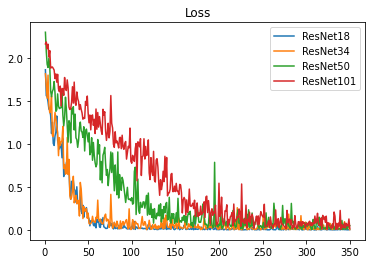

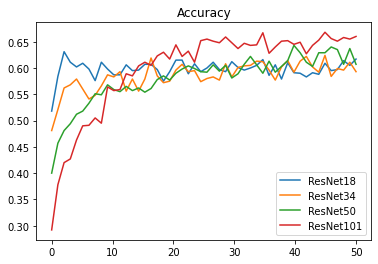

In [ ]:
len_loss = len(loss_f18)
x_loss = np.linspace(1, len_loss, len_loss)
len_acc = len(acc_f18)
x_acc = np.linspace(0, len_acc, len_acc)

plt.figure()
plt.plot(x_loss, loss_f18, x_loss, loss_f34, x_loss, loss_f50, x_loss, loss_f101)
plt.title('Loss')
plt.legend(['ResNet18', 'ResNet34', 'ResNet50', 'ResNet101'])
plt.figure()
plt.plot(x_acc, acc_f18, x_acc, acc_f34, x_acc, acc_f50, x_acc, acc_f101)
plt.title('Accuracy')
plt.legend(['ResNet18', 'ResNet34', 'ResNet50', 'ResNet101'])
plt.show()

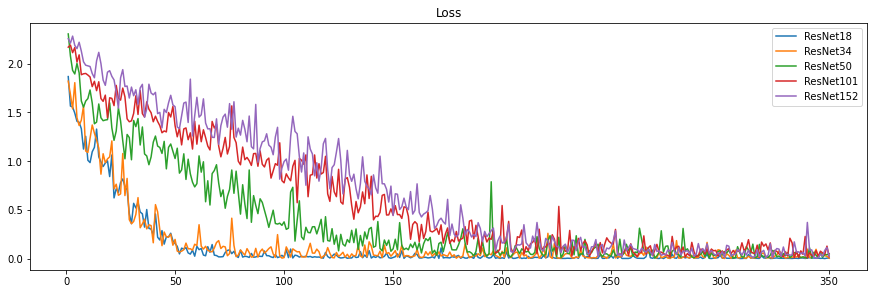

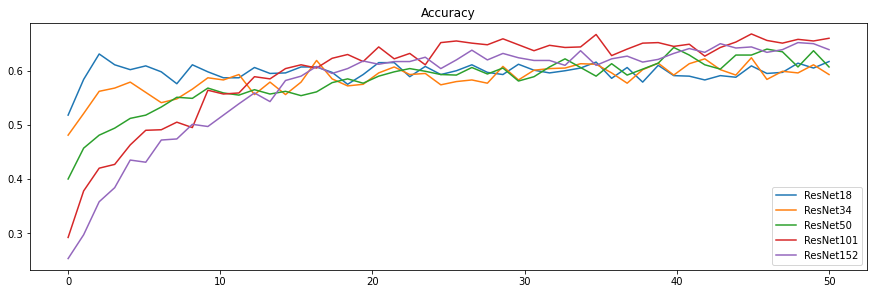

In [19]:
len_loss = len(loss_f18)
x_loss = np.linspace(1, len_loss, len_loss)
len_acc = len(acc_f18)
x_acc = np.linspace(0, len_acc, len_acc)

plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(x_loss, loss_f18, x_loss, loss_f34, x_loss, loss_f50,
         x_loss, loss_f101, x_loss, loss_f152)
plt.title('Loss')
plt.legend(['ResNet18', 'ResNet34', 'ResNet50', 
      'ResNet101', 'ResNet152'])
plt.figure(figsize=(15,10))
plt.subplot(212)
plt.plot(x_acc, acc_f18, x_acc, acc_f34, x_acc, acc_f50,
         x_acc, acc_f101, x_acc, acc_f152)
plt.title('Accuracy')
plt.legend(['ResNet18', 'ResNet34', 'ResNet50', 
      'ResNet101', 'ResNet152'])
plt.show()